### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# the Dice library using tdqm to print progress bar.
# For our use its very annoying because it print one for every generation,
# and we genrating hundreds and sometimes thousands of counterfactuals.

# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Define research parameters

In [5]:
regression_task = False
continuous_features = ['age', 'fnlwgt', 'hours-per-week']
# metric = 'f1'
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
test_size_proportion = 0.1
augment_sample = 0.5
sample_frac = 0.05

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
#     {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
#     {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [6]:
raw_data = pd.read_csv("../datasets/adult.csv")
df = utils.preprocess_adult(raw_data)
target = 'income'

#### split data

In [7]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

# sampled data
df_sample = df.sample(frac=sample_frac, random_state=42)
X_sample = df_sample.drop(target, axis=1)
y_sample = df_sample[target]
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=test_size_proportion, random_state=42)

In [8]:
print('train target distribution:')
display(y_train.value_counts())
print('sampled train target distribution:')
display(y_sample_train.value_counts())
print(f'y_sample_train classes gap: {y_sample_train.value_counts().max()-y_sample_train.value_counts().min()}')

train target distribution:


0    30553
1    10104
Name: income, dtype: int64

sampled train target distribution:


0    1523
1     510
Name: income, dtype: int64

y_sample_train classes gap: 1013


In [9]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [10]:
print(f'whole adult dataset scores:')
_, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df)

whole adult dataset scores:


whole                                        
           f1  accuracy precision    recall   roc_auc
lg   0.614766  0.830235  0.687144  0.557377  0.884911
rf   0.552147  0.822266  0.774684  0.450820  0.878621
xgb  0.633933  0.833333  0.675052  0.589253  0.889692

### Sampled adult dataset scores

In [11]:
print(f'{sample_frac*100}% sampled adult dataset scores:')
_, sampled_scores = utils.fit_and_evaluate(X_sample_train, y_sample_train, X_sample_test, y_sample_test,
                                           search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
sampled_dataset_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index')
sampled_dataset_result_df.columns = pd.MultiIndex.from_product([['sample']] + [sampled_dataset_result_df.columns])
sampled_dataset_result_df

5.0% sampled adult dataset scores:


sample                                        
           f1  accuracy precision    recall   roc_auc
lg   0.543478  0.827434  0.631579  0.510204  0.822553
rf   0.366197  0.805310  0.625000  0.265306  0.827280
xgb  0.527473  0.809735  0.571429  0.489796  0.821400

In [12]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df, sampled_dataset_result_df], axis=1)

### running experiments

In [13]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_sample_train, y_sample_train, X_sample_test, y_sample_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_sample_test, y_sample_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_sample_test, y_sample_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])

    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 13.733153820037842 seconds for settings 0
2 / 4, {'method': 'smote'} 13.482040643692017 seconds for settings 1
3 / 4, {'method': 'cf_random'} model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1013
50/1013
100/1013
150/1013
200/1013
250/1013
300/1013
350/1013
400/1013
450/1013
500/1013
550/1013
600/1013
650/1013
700/1013
750/1013
800/1013
850/1013
900/1013
950/1013
1000/1013
model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1016
50/1016
100/1016
150/1016
200/1016
250/1016
300/1016
350/1016
400/1016
450/1016
500/1016
550/1016
600/1016
650/1016
700/1016
750/1016
800/1016
850/1016
900/1016
950/1016
1000/1016
430.58661580085754 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1013
50/1013
100/1013
150/1013
200/1013
250/1013
300/1013
350/1013
400/1013
450/1013
500/1013
550/1013
600/1013
650/1013


### Results

In [14]:
full_results_df

whole                                            sample            \
           f1  accuracy precision    recall   roc_auc        f1  accuracy   
lg   0.614766  0.830235  0.687144  0.557377  0.884911  0.543478  0.827434   
rf   0.552147  0.822266  0.774684  0.450820  0.878621  0.366197  0.805310   
xgb  0.633933  0.833333  0.675052  0.589253  0.889692  0.527473  0.809735   

                                  random balanced                      \
    precision    recall   roc_auc              f1  accuracy precision   
lg   0.631579  0.510204  0.822553        0.552846  0.756637  0.459459   
rf   0.625000  0.265306  0.827280        0.565517  0.721239  0.427083   
xgb  0.571429  0.489796  0.821400        0.512397  0.738938  0.430556   

                           random                                          \
       recall   roc_auc        f1  accuracy precision    recall   roc_auc   
lg   0.714286  0.820362  0.537634  0.809735  0.615385  0.510204  0.818171   
rf   0.836735  0.830278  0.416667  0.814159  0.588235  0.306122  0.830393   
xgb  0.612245  0.813098  0.479167  0.778761  0.489362  0.489796  0.815865   

    smote balanced                                             smote  \
                f1  accuracy precision    recall   roc_auc        f1   
lg        0.521739  0.756637  0.454545  0.632653  0.805834  0.521739   
rf        0.529412  0.730088  0.428571  0.734694  0.812925  0.529412   
xgb       0.517857  0.756637  0.426230  0.591837  0.802375  0.517857   

                                            cf_random balanced            \
     accuracy precision    recall   roc_auc                 f1  accuracy   
lg   0.756637  0.454545  0.632653  0.805834           0.523364  0.774336   
rf   0.730088  0.428571  0.734694  0.812925           0.557823  0.747788   
xgb  0.756637  0.426230  0.591837  0.802375           0.464286  0.756637   

                                  cf_random                                \
    precision    recall   roc_auc        f1  accuracy precision    recall   
lg   0.482759  0.612245  0.796956  0.545455  0.769912  0.473684  0.612245   
rf   0.444444  0.836735  0.827280  0.569444  0.725664  0.456790  0.857143   
xgb  0.451613  0.530612  0.803874  0.529915  0.756637  0.455882  0.612245   

              cf_genetic balanced                                          \
      roc_auc                  f1  accuracy precision    recall   roc_auc   
lg   0.797071            0.573913  0.783186  0.500000  0.673469  0.808486   
rf   0.831085            0.546763  0.721239  0.422222  0.795918  0.822841   
xgb  0.807910            0.584071  0.792035  0.515625  0.693878  0.810792   

    cf_genetic                                          
            f1  accuracy precision    recall   roc_auc  
lg    0.573913  0.783186   0.50000  0.673469  0.806641  
rf    0.562963  0.738938   0.44186  0.795918  0.822092  
xgb   0.553571  0.778761   0.47541  0.632653  0.817018

In [15]:
print('best methods:')
display(utils.get_best_methods(full_results_df))

best methods:


,f1,accuracy,precision,recall,roc_auc
lg,whole,whole,whole,random balanced,whole
rf,cf_random,whole,whole,cf_random,whole
xgb,whole,whole,whole,cf_genetic balanced,whole
overall,whole,whole,whole,cf_random,whole


In [16]:
utils.save_results_as_latex_tables(full_results_df, task_name="adult")

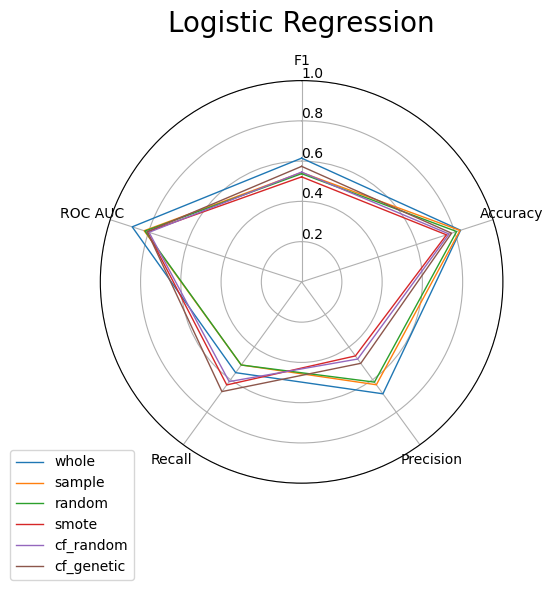

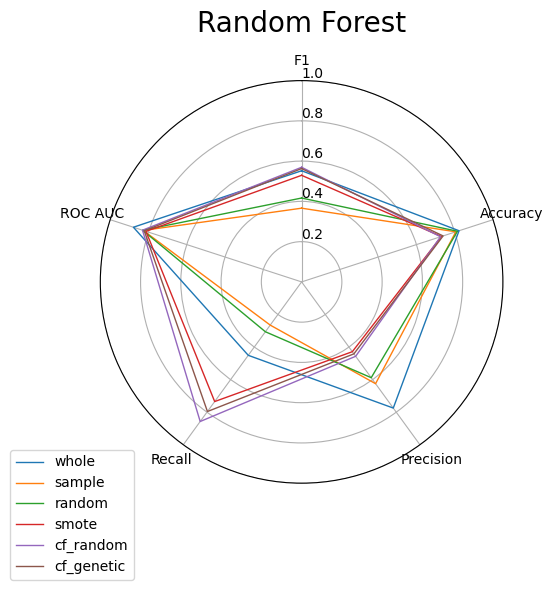

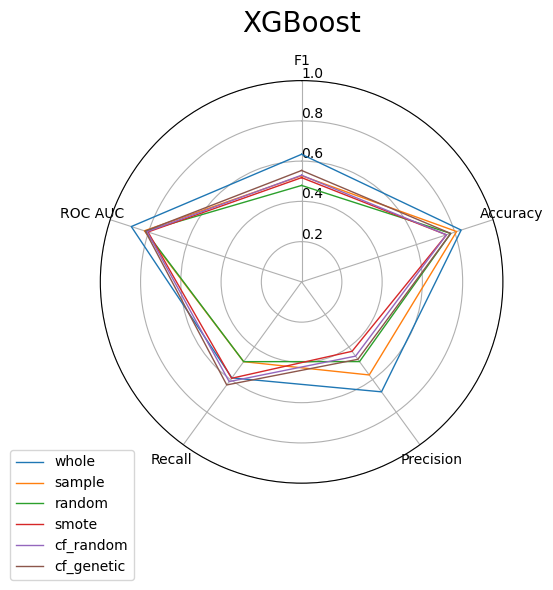

In [17]:
wanted_cols = ['whole', 'sample', 'random', 'smote', 'cf_random', 'cf_genetic']
metric_names = {'f1': 'F1',
                'accuracy': 'Accuracy',
                'precision': 'Precision',
                'recall': 'Recall',
                'roc_auc': 'ROC AUC'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic Regression', save_task_name='adult')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest', save_task_name='adult')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost', save_task_name='adult')

In [18]:
full_results_df.to_csv(rf'../log/experiment_classification_adult_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')